Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.2705, Accuracy: 0.1300
Epoch 2/10, Loss: 2.1669, Accuracy: 0.1916
Epoch 3/10, Loss: 2.0846, Accuracy: 0.2218
Epoch 4/10, Loss: 2.0222, Accuracy: 0.2522
Epoch 5/10, Loss: 1.9884, Accuracy: 0.2578
Epoch 6/10, Loss: 1.9379, Accuracy: 0.2812
Epoch 7/10, Loss: 1.9000, Accuracy: 0.2984
Epoch 8/10, Loss: 1.8873, Accuracy: 0.3042
Epoch 9/10, Loss: 1.8660, Accuracy: 0.3170
Epoch 10/10, Loss: 1.8259, Accuracy: 0.3388


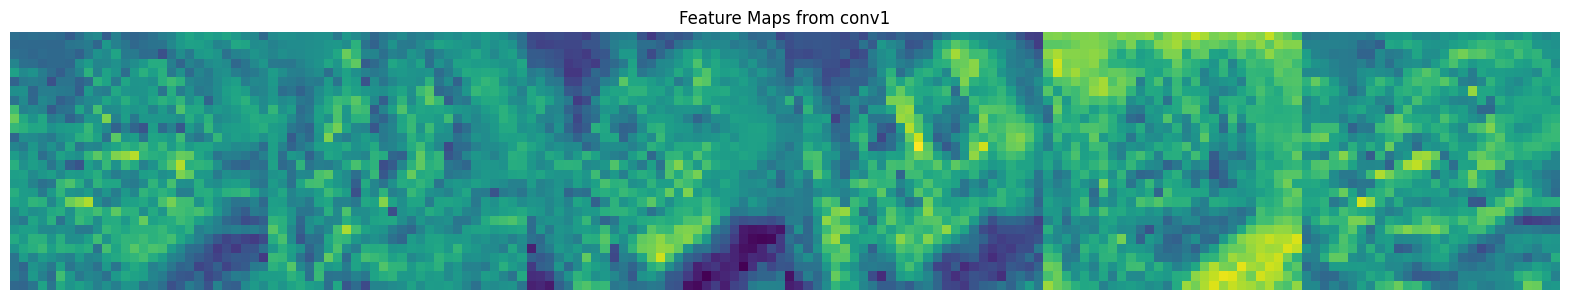

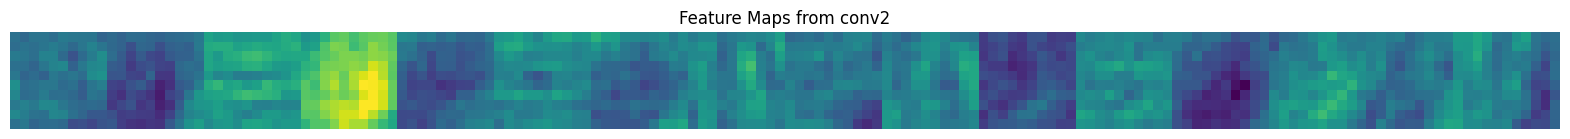

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Data augmentation transformation
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Basic transformation (no augmentation)
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Custom dataset to include both original and augmented images
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, augment_transform):
        self.original_dataset = original_dataset
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.original_dataset) * 2  # Double the dataset size

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            image, label = self.original_dataset[idx]
            return image, label
        else:
            image, label = self.original_dataset[idx - len(self.original_dataset)]
            image = to_pil_image(image)  # Convert tensor to PIL image
            return self.augment_transform(image), label

# Load CIFAR-10 dataset
original_train_dataset = CIFAR10(root='./data', train=True, download=True, transform=basic_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=basic_transform)

# Subset the dataset to 2500 training and 500 test examples
original_train_dataset = Subset(original_train_dataset, range(2500))
test_dataset = Subset(test_dataset, range(500))

# Create augmented training dataset
train_dataset = AugmentedDataset(original_train_dataset, augment_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the LeNet-5 model with batch normalization
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        feature_map1 = x.clone()  # Save feature map from the first layer

        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        feature_map2 = x.clone()  # Save feature map from the second layer

        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)

        return x, feature_map1, feature_map2

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs, _, _ = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

# Feature map visualization
def visualize_feature_maps_pytorch(model, image, layer_names):
    model.eval()

    # Convert tensor to PIL image and back to normalized tensor
    if isinstance(image, torch.Tensor):
        image = to_pil_image(image)
    image = basic_transform(image).unsqueeze(0).to(device)  # Apply transform and add batch dimension

    # Hook to store activations
    activations = {}
    hooks = []

    def hook_fn(layer_name):
        def hook(module, input, output):
            activations[layer_name] = output
        return hook

    for name, layer in model.named_children():
        if name in layer_names:
            hooks.append(layer.register_forward_hook(hook_fn(name)))

    # Forward pass
    with torch.no_grad():
        model(image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Visualize feature maps
    for layer_name, feature_map in activations.items():
        feature_map = feature_map.squeeze(0).cpu().numpy()
        num_filters = feature_map.shape[0]
        grid = np.concatenate([feature_map[i] for i in range(num_filters)], axis=1)

        plt.figure(figsize=(20, 10))
        plt.title(f"Feature Maps from {layer_name}")
        plt.imshow(grid, cmap='viridis')
        plt.axis('off')
        plt.show()

# Visualize feature maps for the first and second convolutional layers
sample_image, _ = test_dataset[0]
visualize_feature_maps_pytorch(model, sample_image, ['conv1', 'conv2'])
